# Effective Kraus Rank

In [1]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_maps import *
from quantum_tools import *
from experiments import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Synthetic Benchmark

### Generate Ground Truth

In [9]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 3
d = 2**n
rank = d
c1 = 0.9
c2 = 0.9

#prep error and full POVM error
spam_target = SPAM(d=d)

init_target = c1*init_ideal(d) + (1-c1)*spam_target.init
povm_target = c2*povm_ideal(d) + (1-c2)*spam_target.povm

spam_target = SPAM(d=d,
                  init = init_target,
                  povm = povm_target)

kraus_target = KrausMap( 
                        U=generate_unitary(d=d), 
                        c=0.5, 
                        d=d, 
                        rank=rank-1,
                        spam = spam_target
                        )

### Generate Synthetic Data

In [10]:
inputs_spam, _ = generate_pauliInput_circuits(n)

U_prep = inputs_spam
N_spam = U_prep.shape[0]

state = tf.repeat(spam_target.init[None,:,:], N_spam, axis=0)
state = apply_unitary(state, U_prep)
targets_spam = measurement(state, povm = spam_target.povm)
targets_spam = targets_spam + tf.cast(tf.random.normal(targets_spam.shape, 0, 0.02/d), dtype = precision)

inputs_map, _ = generate_pauli_circuits(n = n, 
                                        circuit_target=None, 
                                        N = None, 
                                        trace=False)
U_prep, U_basis = inputs_map

N_map = U_prep.shape[0]
state = tf.repeat(tf.expand_dims(spam_target.init, axis=0), N_map, axis=0)
state = apply_unitary(state, U_prep)
state = kraus_target.apply_map(state)
targets_map = measurement(state, U_basis, spam_target.povm) 
targets_map = targets_map + tf.cast(tf.random.normal(targets_map.shape, 0, 0.02/d), dtype = precision)

targets_map_train = targets_map[:5000]
targets_map_val = targets_map[5000:]

inputs_map_train = [inputs_map[0][:5000], inputs_map[1][:5000]]
inputs_map_val = [inputs_map[0][5000:], inputs_map[1][5000:]]

### Fit SPAM Model

In [11]:
spam_model = SPAM(d=d, optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                    num_iter = 300,
                    verbose = False,
                    )

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 1000,
                 verbose = False,
                )

  0%|          | 0/300 [00:00<?, ?it/s]

3.574267274901511e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0005125233505505822


## Un Regularized

In [6]:
np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

model_list = []

for rank in tqdm(range(1,17)):
    kraus_model = KrausMap(
                       d = d, 
                       rank = rank,
                       spam = spam_model,
                       )
    
    model = ModelQuantumMap(
                            q_map = kraus_model,
                            loss = probs_loss,
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                            )
    
    model.train(inputs = inputs_map_train,
                targets = targets_map_train,
                inputs_val = inputs_map_val,
                targets_val = targets_map_val,
                num_iter = 1000,
                N = 1000,
                verbose = False
               )
    model_list.append(model)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.14181510074102832 0.14775098212477755


  0%|          | 0/1000 [00:00<?, ?it/s]

0.05719076592194799 0.060052549809112205


  0%|          | 0/1000 [00:00<?, ?it/s]

0.026483737343665555 0.02909596475753494


  0%|          | 0/1000 [00:00<?, ?it/s]

0.013086809067170907 0.013496016381229018


  0%|          | 0/1000 [00:00<?, ?it/s]

0.007897306201169385 0.007960942480834099


  0%|          | 0/1000 [00:00<?, ?it/s]

0.003917521429009947 0.0041806689183269945


  0%|          | 0/1000 [00:00<?, ?it/s]

0.001886092719726956 0.002096815434599153


  0%|          | 0/1000 [00:00<?, ?it/s]

0.001120804800395433 0.0012190793375514751


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0010877701799485854 0.0011954749847517686


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0010272069763623884 0.0011595826202282628


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0010276940786973657 0.0011517206319935297


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0009928585223844117 0.0010942005837766811


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0010300975386578852 0.0011282676363764713


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0010262159354365752 0.0011313044950791349


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0009803692852612166 0.0011242195102149249


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0010007357485055362 0.0011059139113157573


In [11]:
loss_train = [model.loss_train[-1] for model in model_list]
loss_val = [model.loss_val[-1] for model in model_list]
fidelity = [channel_fidelity(kraus_target, model.q_map) for model in model_list]

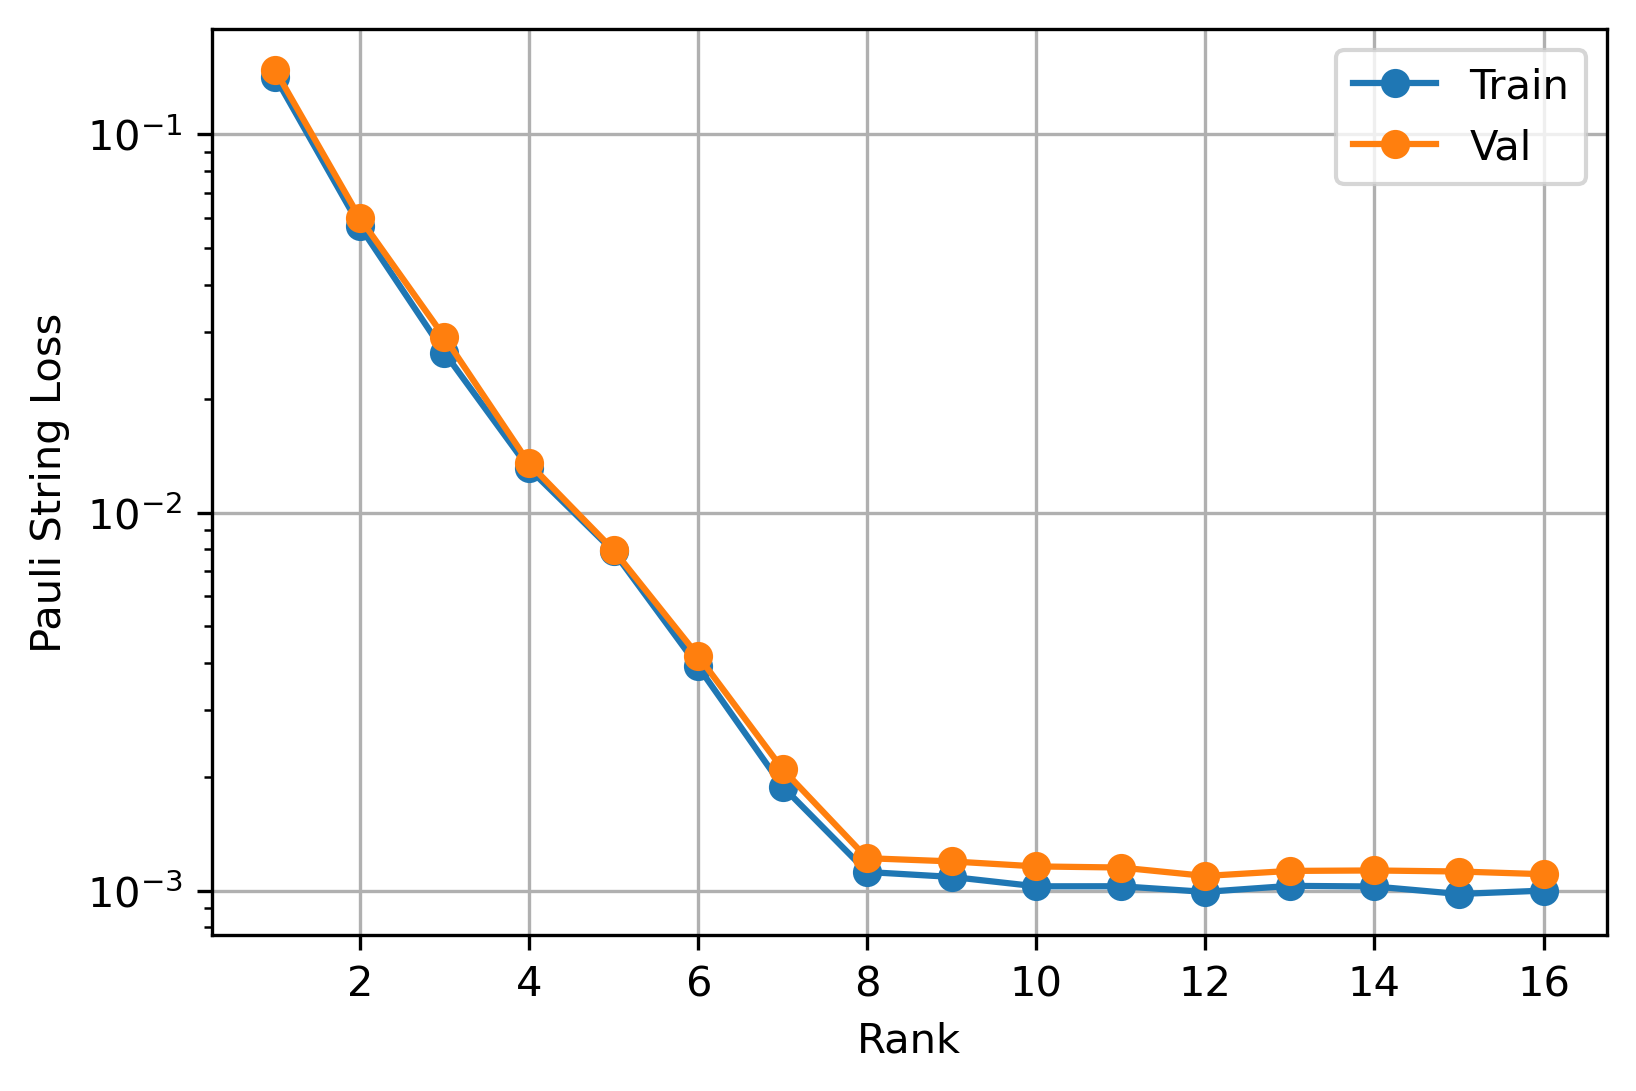

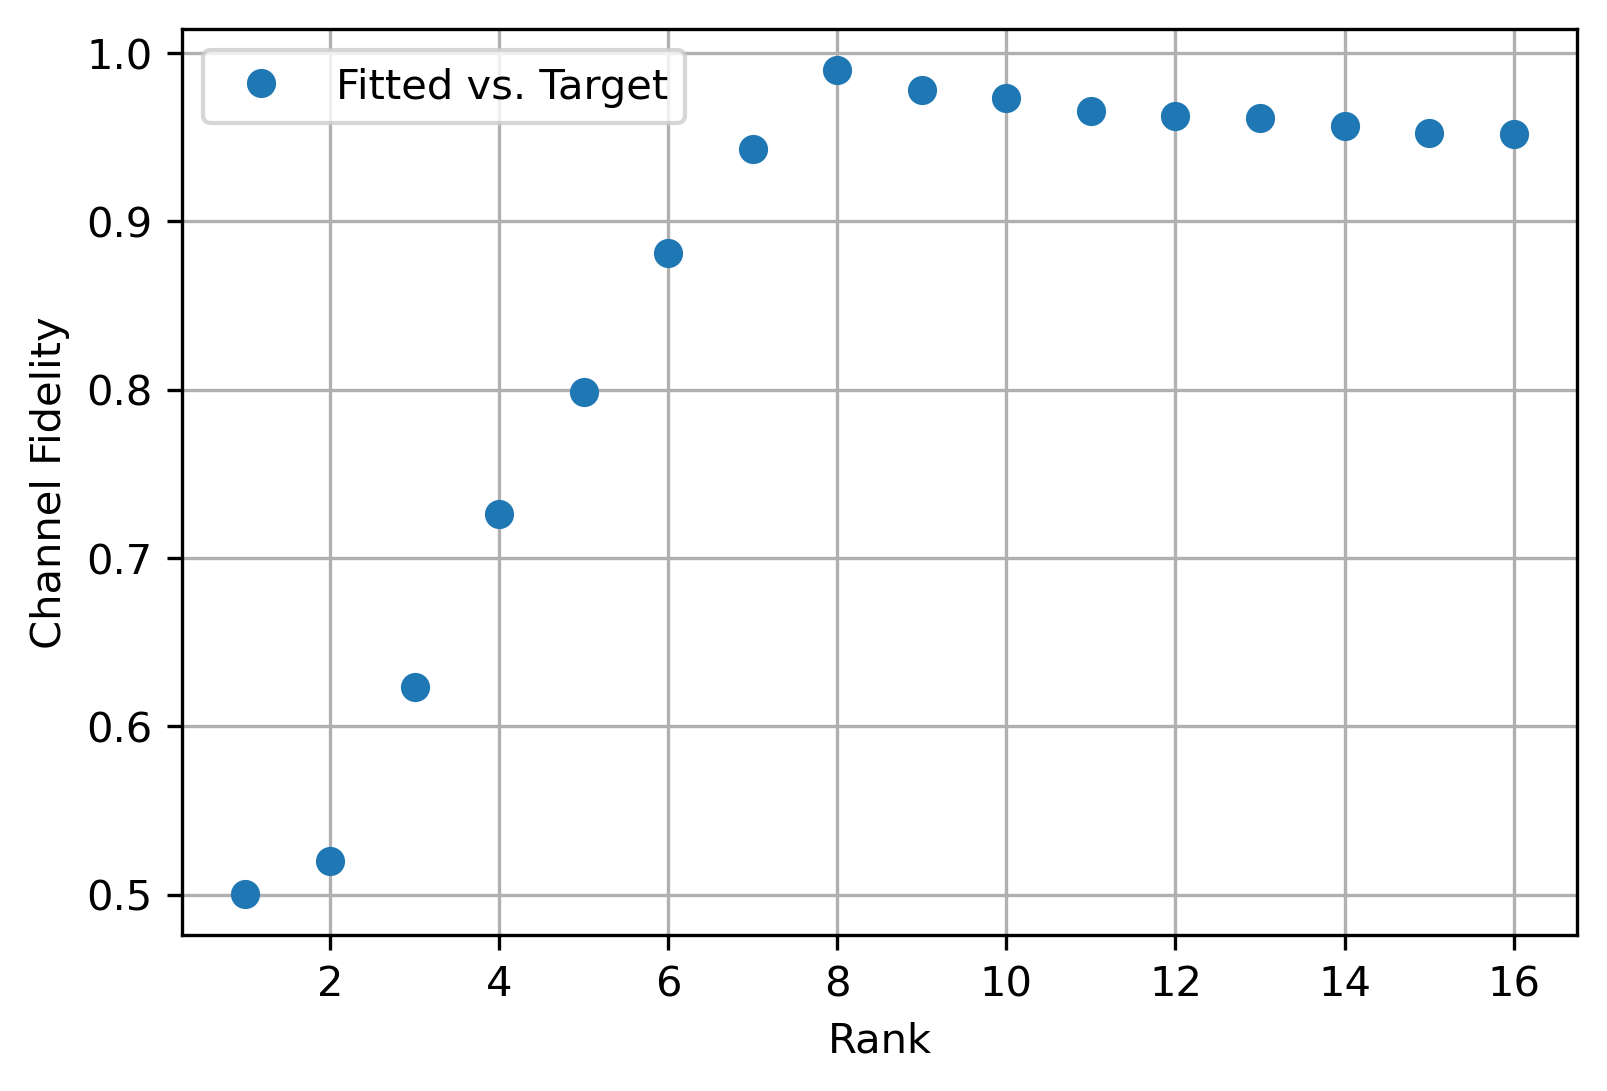

In [18]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.xlabel("Rank")
plt.ylabel("Pauli String Loss")
plt.plot(list(range(1,17)), loss_train, "-o")
plt.plot(list(range(1,17)), loss_val, "-o")
plt.grid()
plt.yscale("log")
plt.legend(["Train","Val"])

plt.show()

fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.xlabel("Rank")
plt.ylabel("Channel Fidelity")
plt.plot(list(range(1,17)) ,fidelity, "o")
plt.legend(["Fitted vs. Target"])
plt.grid()
plt.show()

## Regularized

In [ ]:
np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

model_list = []

for rank in tqdm(range(15,17)):
    kraus_model = KrausMap(
                       d = d, 
                       rank = rank,
                       spam = spam_model,
                       )
    
    model = ModelQuantumMap(
                            q_map = kraus_model,
                            loss = ProbabilityLoss(reg=0.1),
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                            )
    
    model.train(inputs = inputs_map_train,
                targets = targets_map_train,
                inputs_val = inputs_map_val,
                targets_val = targets_map_val,
                num_iter = 1000,
                N = 1000,
                verbose = False
               )
    model_list.append(model)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.28007080552639885 0.2830161809899463


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
loss_train = [model.loss_train[-1] for model in model_list]
loss_val = [model.loss_val[-1] for model in model_list]
fidelity = [channel_fidelity(kraus_target, model.q_map) for model in model_list]

In [ ]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.xlabel("Rank")
plt.ylabel("Pauli String Loss")
plt.plot(list(range(15,17)), loss_train, "-o")
plt.plot(list(range(15,17)), loss_val, "-o")
plt.grid()
plt.yscale("log")
plt.legend(["Train","Val"])

plt.show()

fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.xlabel("Rank")
plt.ylabel("Channel Fidelity")
plt.plot(list(range(8,17)) ,fidelity, "o")
plt.legend(["Fitted vs. Target"])
plt.grid()
plt.show()

## Observation: 

Loss on validation Pauli Strings is strictly decreasing, even for rank>true rank. But channel fidelity shows that rank>true rank causes overfitting not detected by testing on unseen Pauli strings. Why? Hypothesis: Over parameterized models introduce incorrect effects that neither detected or corrected by just simple pauli strings; They go under the radar. But, channel fidelity and train/val loss correspond very nicely up until rank saturation. This is easily detected, from the plot

## Real Hardware

In [58]:
inputs_map, inputs_spam, counts_map_list =  pickle.load(open("../../data/threeQubits_variational_3.p", "rb"))

targets_map = counts_to_probs(counts_map_list[:1000-6**n])
targets_spam = counts_to_probs(counts_map_list[1000-6**n:])

targets_map_train = targets_map[:700]
targets_map_val = targets_map[700:]

inputs_map_train = [inputs_map[0][:700], inputs_map[1][:700]]
inputs_map_val = [inputs_map[0][700:], inputs_map[1][700:]]

n = 3
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

spam_model = SPAM(d=d,
                  use_corr_mat=True,
                  optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                num_iter = 300,
                verbose = False,
                )

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 1000,
                 verbose = False,
                 )

  0%|          | 0/300 [00:00<?, ?it/s]

3.806583107348377e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0005571186473791687


In [59]:
model_list = []
for i in range(1, 17):
    kraus_model = KrausMap(d = d, 
                           rank = i,
                           spam = spam_model,
                           )

    model = ModelQuantumMap(
                            q_map = kraus_model,
                            loss = probs_loss,
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                           )


    model.train(inputs = inputs_map_train,
                targets = targets_map_train,
                inputs_val = inputs_map_val,
                targets_val = targets_map_val,
                num_iter = 1000,
                verbose = False,
                )
    
    model_list.append(model)
    
loss_train1 = [model.loss_train[-1] for model in model_list]
loss_val1 = [model.loss_val[-1] for model in model_list]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.012053207543196122 0.009608711799353954


  0%|          | 0/1000 [00:00<?, ?it/s]

0.006463655137332863 0.006301006146782055


  0%|          | 0/1000 [00:00<?, ?it/s]

0.004623567717787398 0.0061140127811099235


  0%|          | 0/1000 [00:00<?, ?it/s]

0.003956400750378571 0.005381308912089236


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0035779663722607527 0.005129241146905381


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0033393267009410796 0.0053026854827654


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0031195777412949045 0.004970754600606801


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0031152383060693385 0.005108485594566769


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0029980068348657543 0.004927004473811408


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0029478076439860765 0.004847212461060021


  0%|          | 0/1000 [00:00<?, ?it/s]

0.002890421226425588 0.0047586417378399975


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0028836730853504383 0.004621809550872633


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0028070834607008548 0.004796547419738562


  0%|          | 0/1000 [00:00<?, ?it/s]

0.002748903290075438 0.004861064348650682


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0027615750806218487 0.004894336676390459


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0027889102801305367 0.0047216923200235714


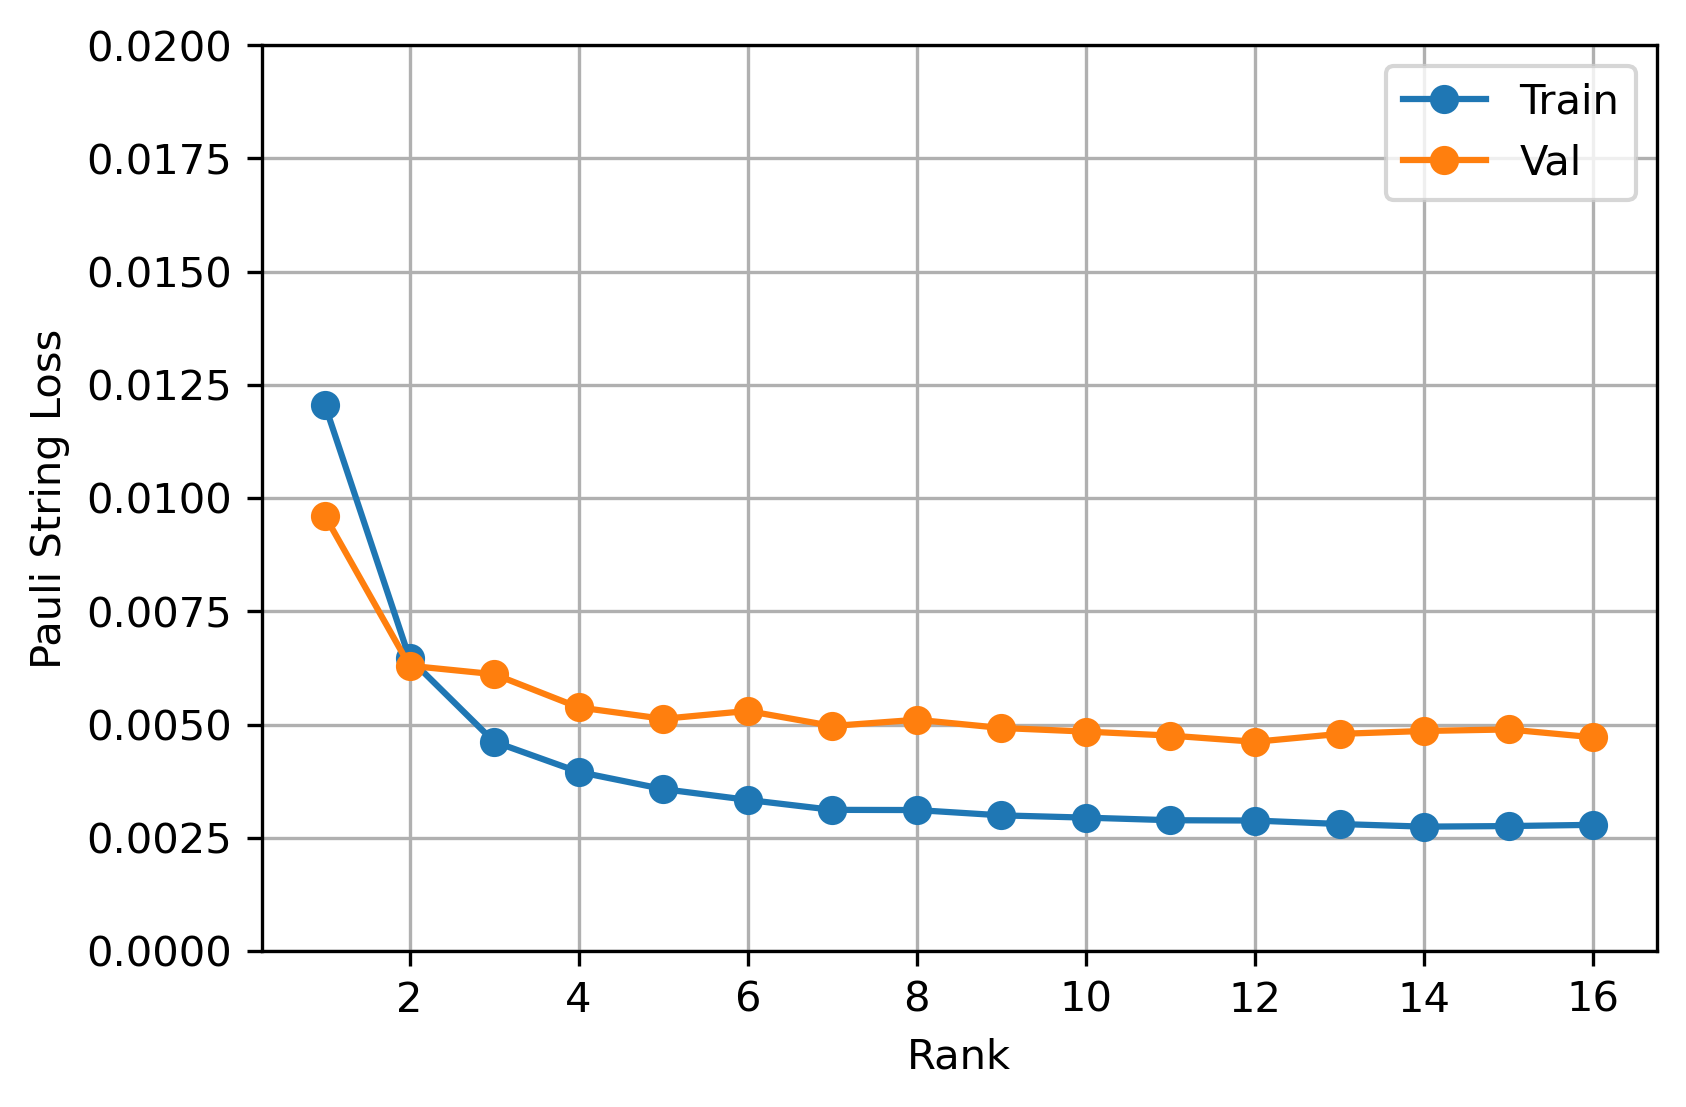

In [75]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
plt.grid()
plt.xlabel("Rank")
plt.ylabel("Pauli String Loss")

plt.plot(list(range(1,17)), loss_train1, "-o")
plt.plot(list(range(1,17)), loss_val1, "-o")

plt.ylim([0, 0.02])
plt.legend(["Train","Val"])
plt.show()

fig.savefig("../../latex/figures/variational_threeLayer_loss.pdf")

### Six Layers

In [61]:
inputs_map, inputs_spam, counts_map_list =  pickle.load(open("../../data/threeQubits_variational_6.p", "rb"))

targets_map = counts_to_probs(counts_map_list[:1000-6**n])
targets_spam = counts_to_probs(counts_map_list[1000-6**n:])

targets_map_train = targets_map[:700]
targets_map_val = targets_map[700:]

inputs_map_train = [inputs_map[0][:700], inputs_map[1][:700]]
inputs_map_val = [inputs_map[0][700:], inputs_map[1][700:]]

n = 3
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

spam_model = SPAM(d=d,
                  use_corr_mat=True,
                  optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                num_iter = 300,
                verbose = False,
                )

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 1000,
                 verbose = False,
                 )

  0%|          | 0/300 [00:00<?, ?it/s]

3.806583107348377e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.000441691987107735


In [62]:
model_list = []
for i in range(1, 17):
    kraus_model = KrausMap(d = d, 
                           rank = i,
                           spam = spam_model,
                           )

    model = ModelQuantumMap(
                            q_map = kraus_model,
                            loss = probs_loss,
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                           )


    model.train(inputs = inputs_map_train,
                targets = targets_map_train,
                inputs_val = inputs_map_val,
                targets_val = targets_map_val,
                num_iter = 1000,
                verbose = False,
                )
    
    model_list.append(model)
    
loss_train2 = [model.loss_train[-1] for model in model_list]
loss_val2 = [model.loss_val[-1] for model in model_list]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.032380270011584715 0.032323747246643


  0%|          | 0/1000 [00:00<?, ?it/s]

0.01411437371934372 0.01734916900316248


  0%|          | 0/1000 [00:00<?, ?it/s]

0.008453864382866954 0.011261306746778395


  0%|          | 0/1000 [00:00<?, ?it/s]

0.006575696208181863 0.00823986434560974


  0%|          | 0/1000 [00:00<?, ?it/s]

0.004902144864007642 0.007053003593744769


  0%|          | 0/1000 [00:00<?, ?it/s]

0.004193438346397867 0.006484576823757731


  0%|          | 0/1000 [00:00<?, ?it/s]

0.00391809616335529 0.0056921345302189145


  0%|          | 0/1000 [00:00<?, ?it/s]

0.003629306019943419 0.005929017963070466


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0035092454034572843 0.005471963763534684


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0032241292837920086 0.005008070663481123


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0031183463294169288 0.004579224827993944


  0%|          | 0/1000 [00:00<?, ?it/s]

0.002941422561094025 0.004496673314333702


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0029616507739676835 0.004573334848372219


  0%|          | 0/1000 [00:00<?, ?it/s]

0.002915008877612943 0.004670417439079392


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0028341712157718218 0.004135439996424771


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0028327784964280334 0.00436577675553057


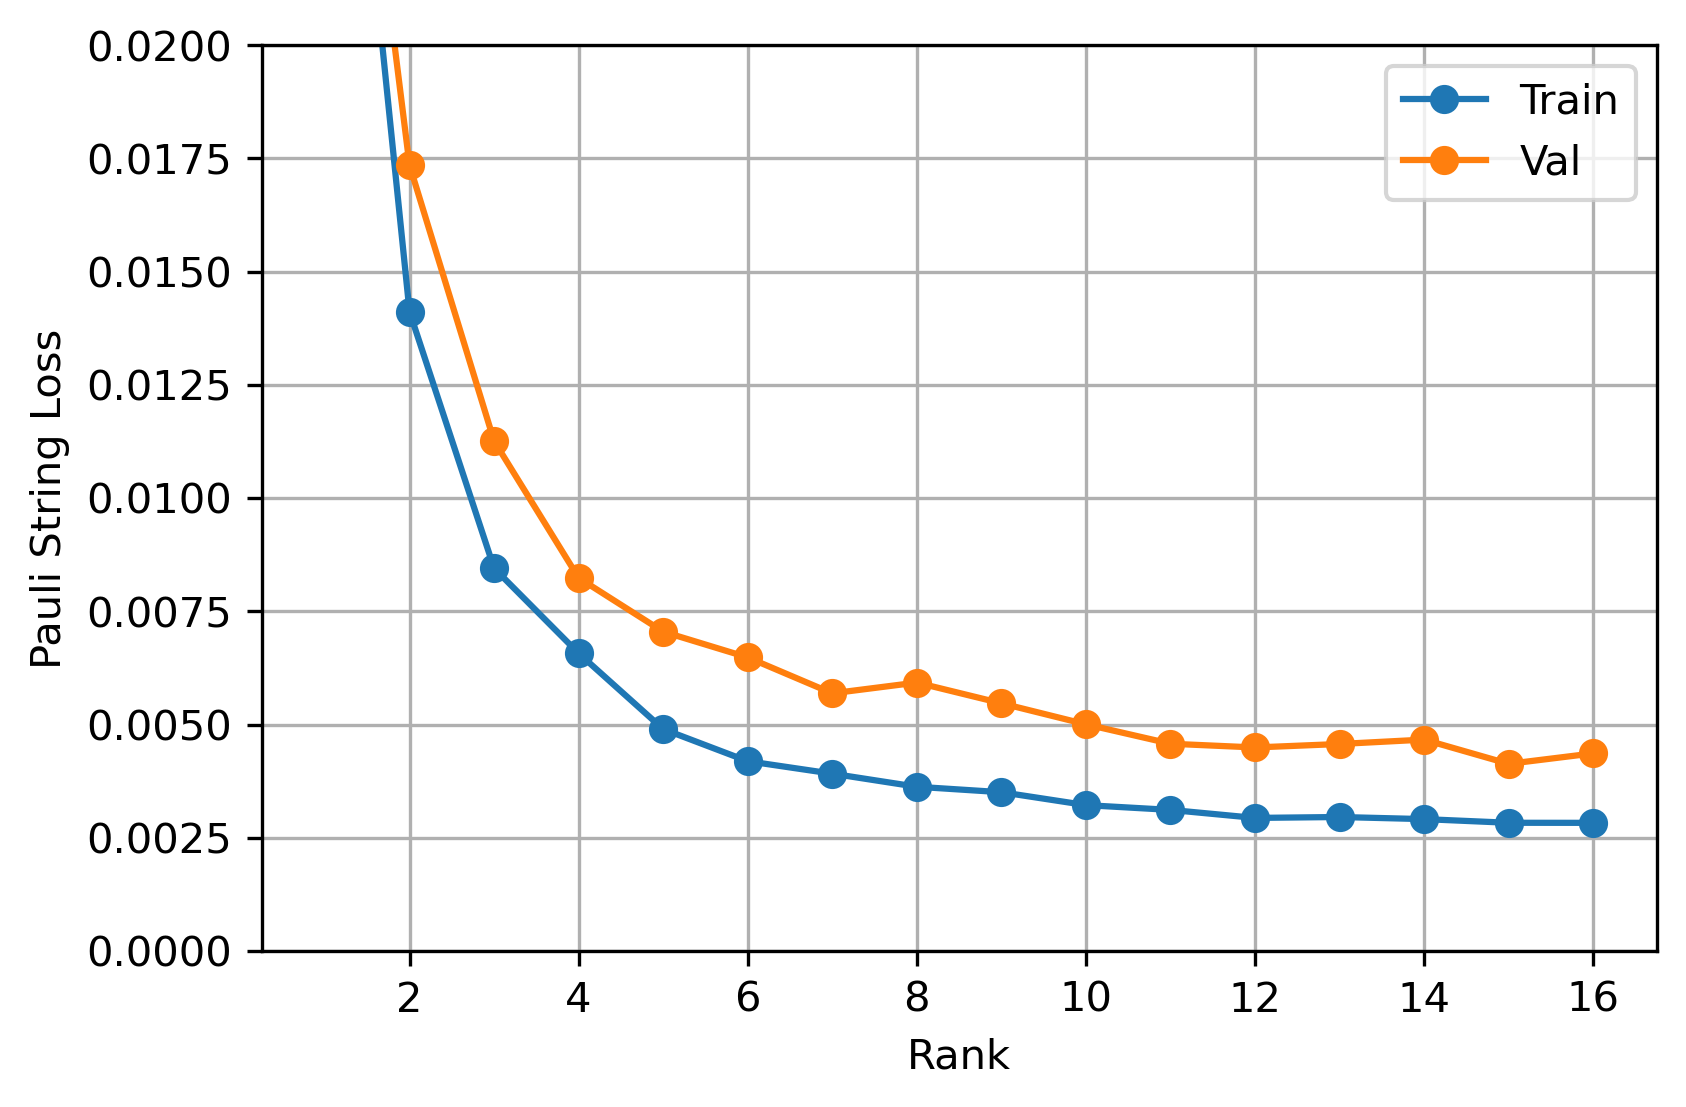

In [74]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.xlabel("Rank")
plt.ylabel("Pauli String Loss")
plt.plot(list(range(1,17)), loss_train2, "-o")
plt.plot(list(range(1,17)), loss_val2, "-o")
plt.grid()
plt.ylim([0, 0.02])
plt.legend(["Train","Val"])
fig.savefig("../../latex/figures/variational_sixLayer_loss.pdf")

plt.show()

### Nine Layers

In [64]:
inputs_map, inputs_spam, counts_map_list =  pickle.load(open("../../data/threeQubits_variational_9.p", "rb"))

targets_map = counts_to_probs(counts_map_list[:1000-6**n])
targets_spam = counts_to_probs(counts_map_list[1000-6**n:])

targets_map_train = targets_map[:700]
targets_map_val = targets_map[700:]

inputs_map_train = [inputs_map[0][:700], inputs_map[1][:700]]
inputs_map_val = [inputs_map[0][700:], inputs_map[1][700:]]

n = 3
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

spam_model = SPAM(d=d,
                  use_corr_mat=True,
                  optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                num_iter = 300,
                verbose = False,
                )

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 1000,
                 verbose = False,
                 )

  0%|          | 0/300 [00:00<?, ?it/s]

3.806583107348377e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0004837367226490718


In [76]:
model_list = []
for i in range(1, 17):
    kraus_model = KrausMap(d = d, 
                           rank = i,
                           spam = spam_model,
                           )

    model = ModelQuantumMap(
                            q_map = kraus_model,
                            loss = probs_loss,
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                           )


    model.train(inputs = inputs_map_train,
                targets = targets_map_train,
                inputs_val = inputs_map_val,
                targets_val = targets_map_val,
                num_iter = 2000,
                verbose = False,
                )
    
    model_list.append(model)
    
loss_train3 = [model.loss_train[-1] for model in model_list]
loss_val3 = [model.loss_val[-1] for model in model_list]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0680211043902595 0.05628604580787126


  0%|          | 0/2000 [00:00<?, ?it/s]

0.02612231562955877 0.0324040053129392


  0%|          | 0/2000 [00:00<?, ?it/s]

0.014859069692352197 0.0212721185719287


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009824840411264723 0.01697492750282975


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007662987948843255 0.013849694801398351


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006403876166107761 0.012044835195252625


  0%|          | 0/2000 [00:00<?, ?it/s]

0.005561595282208377 0.0121149367775444


  0%|          | 0/2000 [00:00<?, ?it/s]

0.004681280006540134 0.010303794969517938


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0043605206666996925 0.009447748124445527


  0%|          | 0/2000 [00:00<?, ?it/s]

0.004056311345683067 0.009677059310059305


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003838179482806089 0.00944100927394364


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003698749896050301 0.008802647047665127


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003608115626682004 0.008286720465393544


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0034863705785833613 0.008278810354004304


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003389357017551611 0.007891124605111545


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003393368554898616 0.008217247631636266


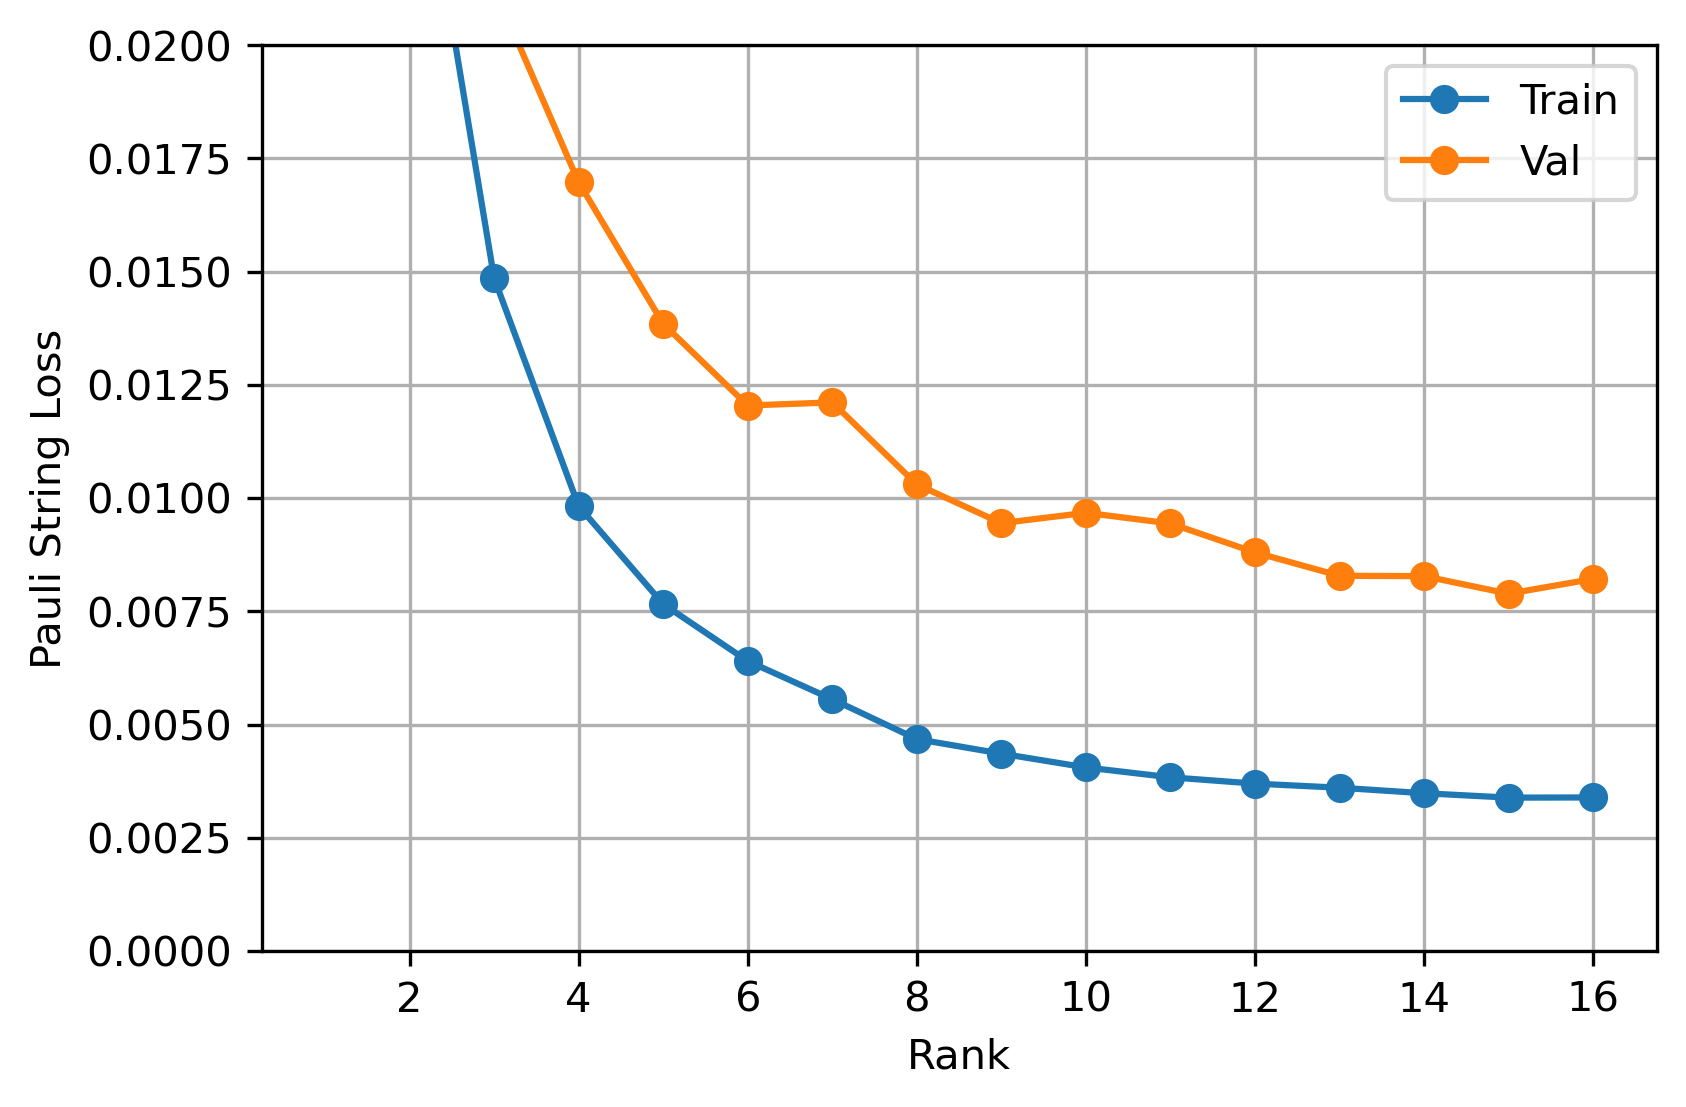

In [77]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.xlabel("Rank")
plt.ylabel("Pauli String Loss")
plt.plot(list(range(1,17)), loss_train3, "-o")
plt.plot(list(range(1,17)), loss_val3, "-o")
plt.ylim([0, 0.02])
plt.grid()
plt.legend(["Train","Val"])
fig.savefig("../../latex/figures/variational_nineLayer_loss.pdf")

plt.show()

# Effective Rank Heuristic

In [26]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
n = 2
d = 2**n
rank_list = np.array([i+1 for i in range(d**2)])

rank_eff_list = []
for i in tqdm(rank_list):
    rank_eff = 0
    for j in range(100):
        kraus_model = KrausMap(
                               d = d, 
                               rank = i,
                               )
        rank_eff += effective_rank(kraus_model)
    rank_eff_list.append(rank_eff/100)

  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\krist\AppData\Local\Temp\ipykernel_1960\2261722210.py:8: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001F9ACB1F6D0> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_", "Effective Rank", "Rank_eff = 8"])


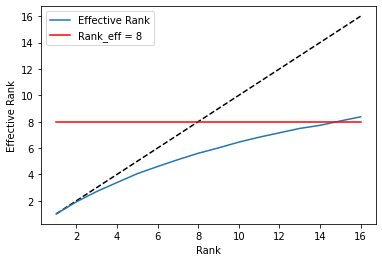

In [27]:
y = rank_list/(1 + (np.log2(rank_list)/np.log2(d**2))**(n+1))
plt.plot(rank_list, rank_list, "k--")
plt.plot(rank_list, rank_eff_list)
#plt.plot(rank_list, y)
plt.plot([1, d**2], [d**2/2, d**2/2], "r")
plt.xlabel("Rank")
plt.ylabel("Effective Rank")
plt.legend(["_", "Effective Rank", "Rank_eff = 8"])
plt.show()

In [33]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
n = 3
d = 2**n
rank_list = np.array([i+1 for i in range(d**2)])

rank_eff_list = []
for i in tqdm(rank_list):
    rank_eff = 0
    for j in range(10):
        kraus_model = KrausMap(
                               d = d, 
                               rank = i,
                               )
        rank_eff += effective_rank(kraus_model)
    rank_eff_list.append(rank_eff/10)

  0%|          | 0/64 [00:00<?, ?it/s]

C:\Users\krist\AppData\Local\Temp\ipykernel_1960\3770437324.py:8: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001F9ADC51AB0> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_", "Effective Rank", "Rank_eff = 32"])


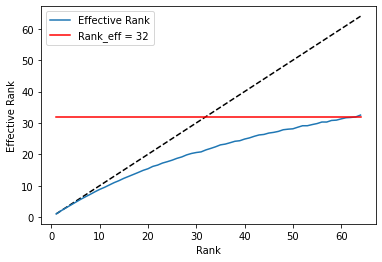

In [34]:
y = rank_list/(1 + (np.log2(rank_list)/np.log2(d**2))**(n+1))
plt.plot(rank_list, rank_list, "k--")
plt.plot(rank_list, rank_eff_list)
#plt.plot(rank_list, y)
plt.plot([1, d**2], [d**2/2, d**2/2], "r")
plt.xlabel("Rank")
plt.ylabel("Effective Rank")
plt.legend(["_", "Effective Rank", "Rank_eff = 32"])
plt.show()

In [35]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
n = 4
d = 2**n
rank_list = np.array([i+1 for i in range(d**2)])

rank_eff_list = []
for i in tqdm(rank_list):
    rank_eff = 0
    for j in range(1):
        kraus_model = KrausMap(
                               d = d, 
                               rank = i,
                               )
        rank_eff += effective_rank(kraus_model)
    rank_eff_list.append(rank_eff)

  0%|          | 0/256 [00:00<?, ?it/s]

C:\Users\krist\AppData\Local\Temp\ipykernel_1960\3742944198.py:8: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001F9ACC1C520> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_", "Effective Rank", "Rank_eff = 128"])


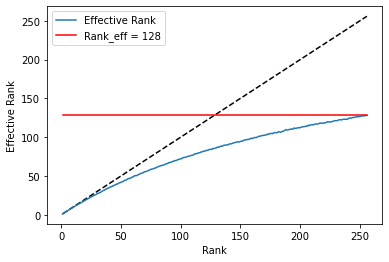

In [32]:
y = rank_list/(1 + (np.log2(rank_list)/np.log2(d**2))**(n+1))
plt.plot(rank_list, rank_list, "k--")
plt.plot(rank_list, rank_eff_list)
#plt.plot(rank_list, y)
plt.plot([1, d**2], [d**2/2, d**2/2], "r")
plt.xlabel("Rank")
plt.ylabel("Effective Rank")
plt.legend(["_", "Effective Rank", "Rank_eff = 128"])
plt.show()

## Map Inflation

In [3]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
n = 3
d = 2**n

kraus_unitary = KrausMap(d = d, 
                         rank = 1)

model_unitary = ModelQuantumMap(
                                q_map = kraus_unitary,
                                loss = RankShrink(inflate=True),
                                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                               )

kraus_full = KrausMap(d = d, 
                      rank = d**2)

model_full = ModelQuantumMap(
                             q_map = kraus_full,
                             loss = RankShrink(inflate=True),
                             optimizer = tf.optimizers.Adam(learning_rate=0.01),
                            )
print(effective_rank(kraus_unitary))
print(effective_rank(kraus_full))

tf.Tensor((0.9999999999999996-1.9411190943093674e-16j), shape=(), dtype=complex128)
tf.Tensor((32.460697629261574-2.2104878644960906e-16j), shape=(), dtype=complex128)


In [4]:
model_unitary.train(inputs = [],
                    targets = [],
                    num_iter = 1000,
                    verbose = True,
                    use_batch = False,
                   )

model_full.train(inputs = [],
                    targets = [],
                    num_iter = 1000,
                    verbose = True,
                    use_batch = False,
                   )

  0%|          | 0/1000 [00:00<?, ?it/s]

Step:0, train: 0.01562, val: 0.00000
Step:1, train: 0.01563, val: 0.00000
Step:2, train: 0.01563, val: 0.00000
Step:3, train: 0.01563, val: 0.00000
Step:4, train: 0.01562, val: 0.00000
Step:5, train: 0.01562, val: 0.00000
Step:6, train: 0.01562, val: 0.00000
Step:7, train: 0.01563, val: 0.00000
Step:8, train: 0.01562, val: 0.00000
Step:9, train: 0.01562, val: 0.00000
Step:10, train: 0.01562, val: 0.00000
Step:11, train: 0.01563, val: 0.00000
Step:12, train: 0.01562, val: 0.00000
Step:13, train: 0.01562, val: 0.00000
Step:14, train: 0.01562, val: 0.00000
Step:15, train: 0.01563, val: 0.00000
Step:16, train: 0.01563, val: 0.00000
Step:17, train: 0.01563, val: 0.00000
Step:18, train: 0.01562, val: 0.00000
Step:19, train: 0.01563, val: 0.00000
Step:20, train: 0.01563, val: 0.00000
Step:21, train: 0.01562, val: 0.00000
Step:22, train: 0.01563, val: 0.00000
Step:23, train: 0.01562, val: 0.00000
Step:24, train: 0.01563, val: 0.00000
Step:25, train: 0.01562, val: 0.00000
Step:26, train: 0.0156

Step:220, train: 0.01563, val: 0.00000
Step:221, train: 0.01562, val: 0.00000
Step:222, train: 0.01562, val: 0.00000
Step:223, train: 0.01563, val: 0.00000
Step:224, train: 0.01562, val: 0.00000
Step:225, train: 0.01563, val: 0.00000
Step:226, train: 0.01563, val: 0.00000
Step:227, train: 0.01563, val: 0.00000
Step:228, train: 0.01563, val: 0.00000
Step:229, train: 0.01563, val: 0.00000
Step:230, train: 0.01563, val: 0.00000
Step:231, train: 0.01563, val: 0.00000
Step:232, train: 0.01563, val: 0.00000
Step:233, train: 0.01562, val: 0.00000
Step:234, train: 0.01563, val: 0.00000
Step:235, train: 0.01562, val: 0.00000
Step:236, train: 0.01562, val: 0.00000
Step:237, train: 0.01563, val: 0.00000
Step:238, train: 0.01562, val: 0.00000
Step:239, train: 0.01562, val: 0.00000
Step:240, train: 0.01563, val: 0.00000
Step:241, train: 0.01563, val: 0.00000
Step:242, train: 0.01563, val: 0.00000
Step:243, train: 0.01562, val: 0.00000
Step:244, train: 0.01563, val: 0.00000
Step:245, train: 0.01563,

Step:436, train: 0.01563, val: 0.00000
Step:437, train: 0.01562, val: 0.00000
Step:438, train: 0.01562, val: 0.00000
Step:439, train: 0.01562, val: 0.00000
Step:440, train: 0.01562, val: 0.00000
Step:441, train: 0.01563, val: 0.00000
Step:442, train: 0.01563, val: 0.00000
Step:443, train: 0.01563, val: 0.00000
Step:444, train: 0.01562, val: 0.00000
Step:445, train: 0.01562, val: 0.00000
Step:446, train: 0.01563, val: 0.00000
Step:447, train: 0.01563, val: 0.00000
Step:448, train: 0.01562, val: 0.00000
Step:449, train: 0.01563, val: 0.00000
Step:450, train: 0.01562, val: 0.00000
Step:451, train: 0.01563, val: 0.00000
Step:452, train: 0.01562, val: 0.00000
Step:453, train: 0.01563, val: 0.00000
Step:454, train: 0.01563, val: 0.00000
Step:455, train: 0.01562, val: 0.00000
Step:456, train: 0.01563, val: 0.00000
Step:457, train: 0.01562, val: 0.00000
Step:458, train: 0.01563, val: 0.00000
Step:459, train: 0.01562, val: 0.00000
Step:460, train: 0.01563, val: 0.00000
Step:461, train: 0.01563,

Step:658, train: 0.01562, val: 0.00000
Step:659, train: 0.01563, val: 0.00000
Step:660, train: 0.01563, val: 0.00000
Step:661, train: 0.01562, val: 0.00000
Step:662, train: 0.01562, val: 0.00000
Step:663, train: 0.01562, val: 0.00000
Step:664, train: 0.01562, val: 0.00000
Step:665, train: 0.01563, val: 0.00000
Step:666, train: 0.01562, val: 0.00000
Step:667, train: 0.01562, val: 0.00000
Step:668, train: 0.01562, val: 0.00000
Step:669, train: 0.01562, val: 0.00000
Step:670, train: 0.01563, val: 0.00000
Step:671, train: 0.01562, val: 0.00000
Step:672, train: 0.01563, val: 0.00000
Step:673, train: 0.01562, val: 0.00000
Step:674, train: 0.01563, val: 0.00000
Step:675, train: 0.01562, val: 0.00000
Step:676, train: 0.01563, val: 0.00000
Step:677, train: 0.01562, val: 0.00000
Step:678, train: 0.01562, val: 0.00000
Step:679, train: 0.01562, val: 0.00000
Step:680, train: 0.01563, val: 0.00000
Step:681, train: 0.01562, val: 0.00000
Step:682, train: 0.01562, val: 0.00000
Step:683, train: 0.01563,

Step:878, train: 0.01563, val: 0.00000
Step:879, train: 0.01562, val: 0.00000
Step:880, train: 0.01562, val: 0.00000
Step:881, train: 0.01563, val: 0.00000
Step:882, train: 0.01562, val: 0.00000
Step:883, train: 0.01562, val: 0.00000
Step:884, train: 0.01563, val: 0.00000
Step:885, train: 0.01562, val: 0.00000
Step:886, train: 0.01562, val: 0.00000
Step:887, train: 0.01562, val: 0.00000
Step:888, train: 0.01563, val: 0.00000
Step:889, train: 0.01563, val: 0.00000
Step:890, train: 0.01562, val: 0.00000
Step:891, train: 0.01562, val: 0.00000
Step:892, train: 0.01562, val: 0.00000
Step:893, train: 0.01563, val: 0.00000
Step:894, train: 0.01562, val: 0.00000
Step:895, train: 0.01562, val: 0.00000
Step:896, train: 0.01562, val: 0.00000
Step:897, train: 0.01563, val: 0.00000
Step:898, train: 0.01562, val: 0.00000
Step:899, train: 0.01563, val: 0.00000
Step:900, train: 0.01563, val: 0.00000
Step:901, train: 0.01562, val: 0.00000
Step:902, train: 0.01562, val: 0.00000
Step:903, train: 0.01562,

  0%|          | 0/1000 [00:00<?, ?it/s]

Step:0, train: 0.50720, val: 0.00000
Step:1, train: 0.51521, val: 0.00000
Step:2, train: 0.52322, val: 0.00000
Step:3, train: 0.53122, val: 0.00000
Step:4, train: 0.53921, val: 0.00000
Step:5, train: 0.54717, val: 0.00000
Step:6, train: 0.55510, val: 0.00000
Step:7, train: 0.56300, val: 0.00000
Step:8, train: 0.57086, val: 0.00000
Step:9, train: 0.57867, val: 0.00000
Step:10, train: 0.58643, val: 0.00000
Step:11, train: 0.59414, val: 0.00000
Step:12, train: 0.60178, val: 0.00000
Step:13, train: 0.60936, val: 0.00000
Step:14, train: 0.61688, val: 0.00000
Step:15, train: 0.62433, val: 0.00000
Step:16, train: 0.63172, val: 0.00000
Step:17, train: 0.63905, val: 0.00000
Step:18, train: 0.64631, val: 0.00000
Step:19, train: 0.65350, val: 0.00000
Step:20, train: 0.66062, val: 0.00000
Step:21, train: 0.66767, val: 0.00000
Step:22, train: 0.67465, val: 0.00000
Step:23, train: 0.68156, val: 0.00000
Step:24, train: 0.68839, val: 0.00000
Step:25, train: 0.69515, val: 0.00000
Step:26, train: 0.7018

Step:214, train: 0.99985, val: 0.00000
Step:215, train: 0.99986, val: 0.00000
Step:216, train: 0.99986, val: 0.00000
Step:217, train: 0.99986, val: 0.00000
Step:218, train: 0.99986, val: 0.00000
Step:219, train: 0.99986, val: 0.00000
Step:220, train: 0.99987, val: 0.00000
Step:221, train: 0.99987, val: 0.00000
Step:222, train: 0.99987, val: 0.00000
Step:223, train: 0.99987, val: 0.00000
Step:224, train: 0.99987, val: 0.00000
Step:225, train: 0.99987, val: 0.00000
Step:226, train: 0.99987, val: 0.00000
Step:227, train: 0.99987, val: 0.00000
Step:228, train: 0.99987, val: 0.00000
Step:229, train: 0.99987, val: 0.00000
Step:230, train: 0.99987, val: 0.00000
Step:231, train: 0.99988, val: 0.00000
Step:232, train: 0.99988, val: 0.00000
Step:233, train: 0.99988, val: 0.00000
Step:234, train: 0.99987, val: 0.00000
Step:235, train: 0.99987, val: 0.00000
Step:236, train: 0.99987, val: 0.00000
Step:237, train: 0.99987, val: 0.00000
Step:238, train: 0.99987, val: 0.00000
Step:239, train: 0.99987,

Step:426, train: 0.99984, val: 0.00000
Step:427, train: 0.99984, val: 0.00000
Step:428, train: 0.99984, val: 0.00000
Step:429, train: 0.99984, val: 0.00000
Step:430, train: 0.99984, val: 0.00000
Step:431, train: 0.99985, val: 0.00000
Step:432, train: 0.99985, val: 0.00000
Step:433, train: 0.99986, val: 0.00000
Step:434, train: 0.99986, val: 0.00000
Step:435, train: 0.99986, val: 0.00000
Step:436, train: 0.99985, val: 0.00000
Step:437, train: 0.99985, val: 0.00000
Step:438, train: 0.99984, val: 0.00000
Step:439, train: 0.99984, val: 0.00000
Step:440, train: 0.99984, val: 0.00000
Step:441, train: 0.99984, val: 0.00000
Step:442, train: 0.99984, val: 0.00000
Step:443, train: 0.99984, val: 0.00000
Step:444, train: 0.99984, val: 0.00000
Step:445, train: 0.99984, val: 0.00000
Step:446, train: 0.99984, val: 0.00000
Step:447, train: 0.99983, val: 0.00000
Step:448, train: 0.99983, val: 0.00000
Step:449, train: 0.99983, val: 0.00000
Step:450, train: 0.99983, val: 0.00000
Step:451, train: 0.99982,

Step:638, train: 0.99959, val: 0.00000
Step:639, train: 0.99959, val: 0.00000
Step:640, train: 0.99959, val: 0.00000
Step:641, train: 0.99958, val: 0.00000
Step:642, train: 0.99958, val: 0.00000
Step:643, train: 0.99958, val: 0.00000
Step:644, train: 0.99958, val: 0.00000
Step:645, train: 0.99959, val: 0.00000
Step:646, train: 0.99959, val: 0.00000
Step:647, train: 0.99959, val: 0.00000
Step:648, train: 0.99958, val: 0.00000
Step:649, train: 0.99958, val: 0.00000
Step:650, train: 0.99957, val: 0.00000
Step:651, train: 0.99957, val: 0.00000
Step:652, train: 0.99957, val: 0.00000
Step:653, train: 0.99957, val: 0.00000
Step:654, train: 0.99957, val: 0.00000
Step:655, train: 0.99957, val: 0.00000
Step:656, train: 0.99957, val: 0.00000
Step:657, train: 0.99957, val: 0.00000
Step:658, train: 0.99957, val: 0.00000
Step:659, train: 0.99958, val: 0.00000
Step:660, train: 0.99957, val: 0.00000
Step:661, train: 0.99957, val: 0.00000
Step:662, train: 0.99957, val: 0.00000
Step:663, train: 0.99957,

KeyboardInterrupt: 

In [5]:
print(effective_rank(kraus_unitary))
print(effective_rank(kraus_full))

tf.Tensor((1.0000000000000004-2.775442705579749e-17j), shape=(), dtype=complex128)
tf.Tensor((63.96930133504176+1.1237245089388293e-15j), shape=(), dtype=complex128)


C:\Program Files\Anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


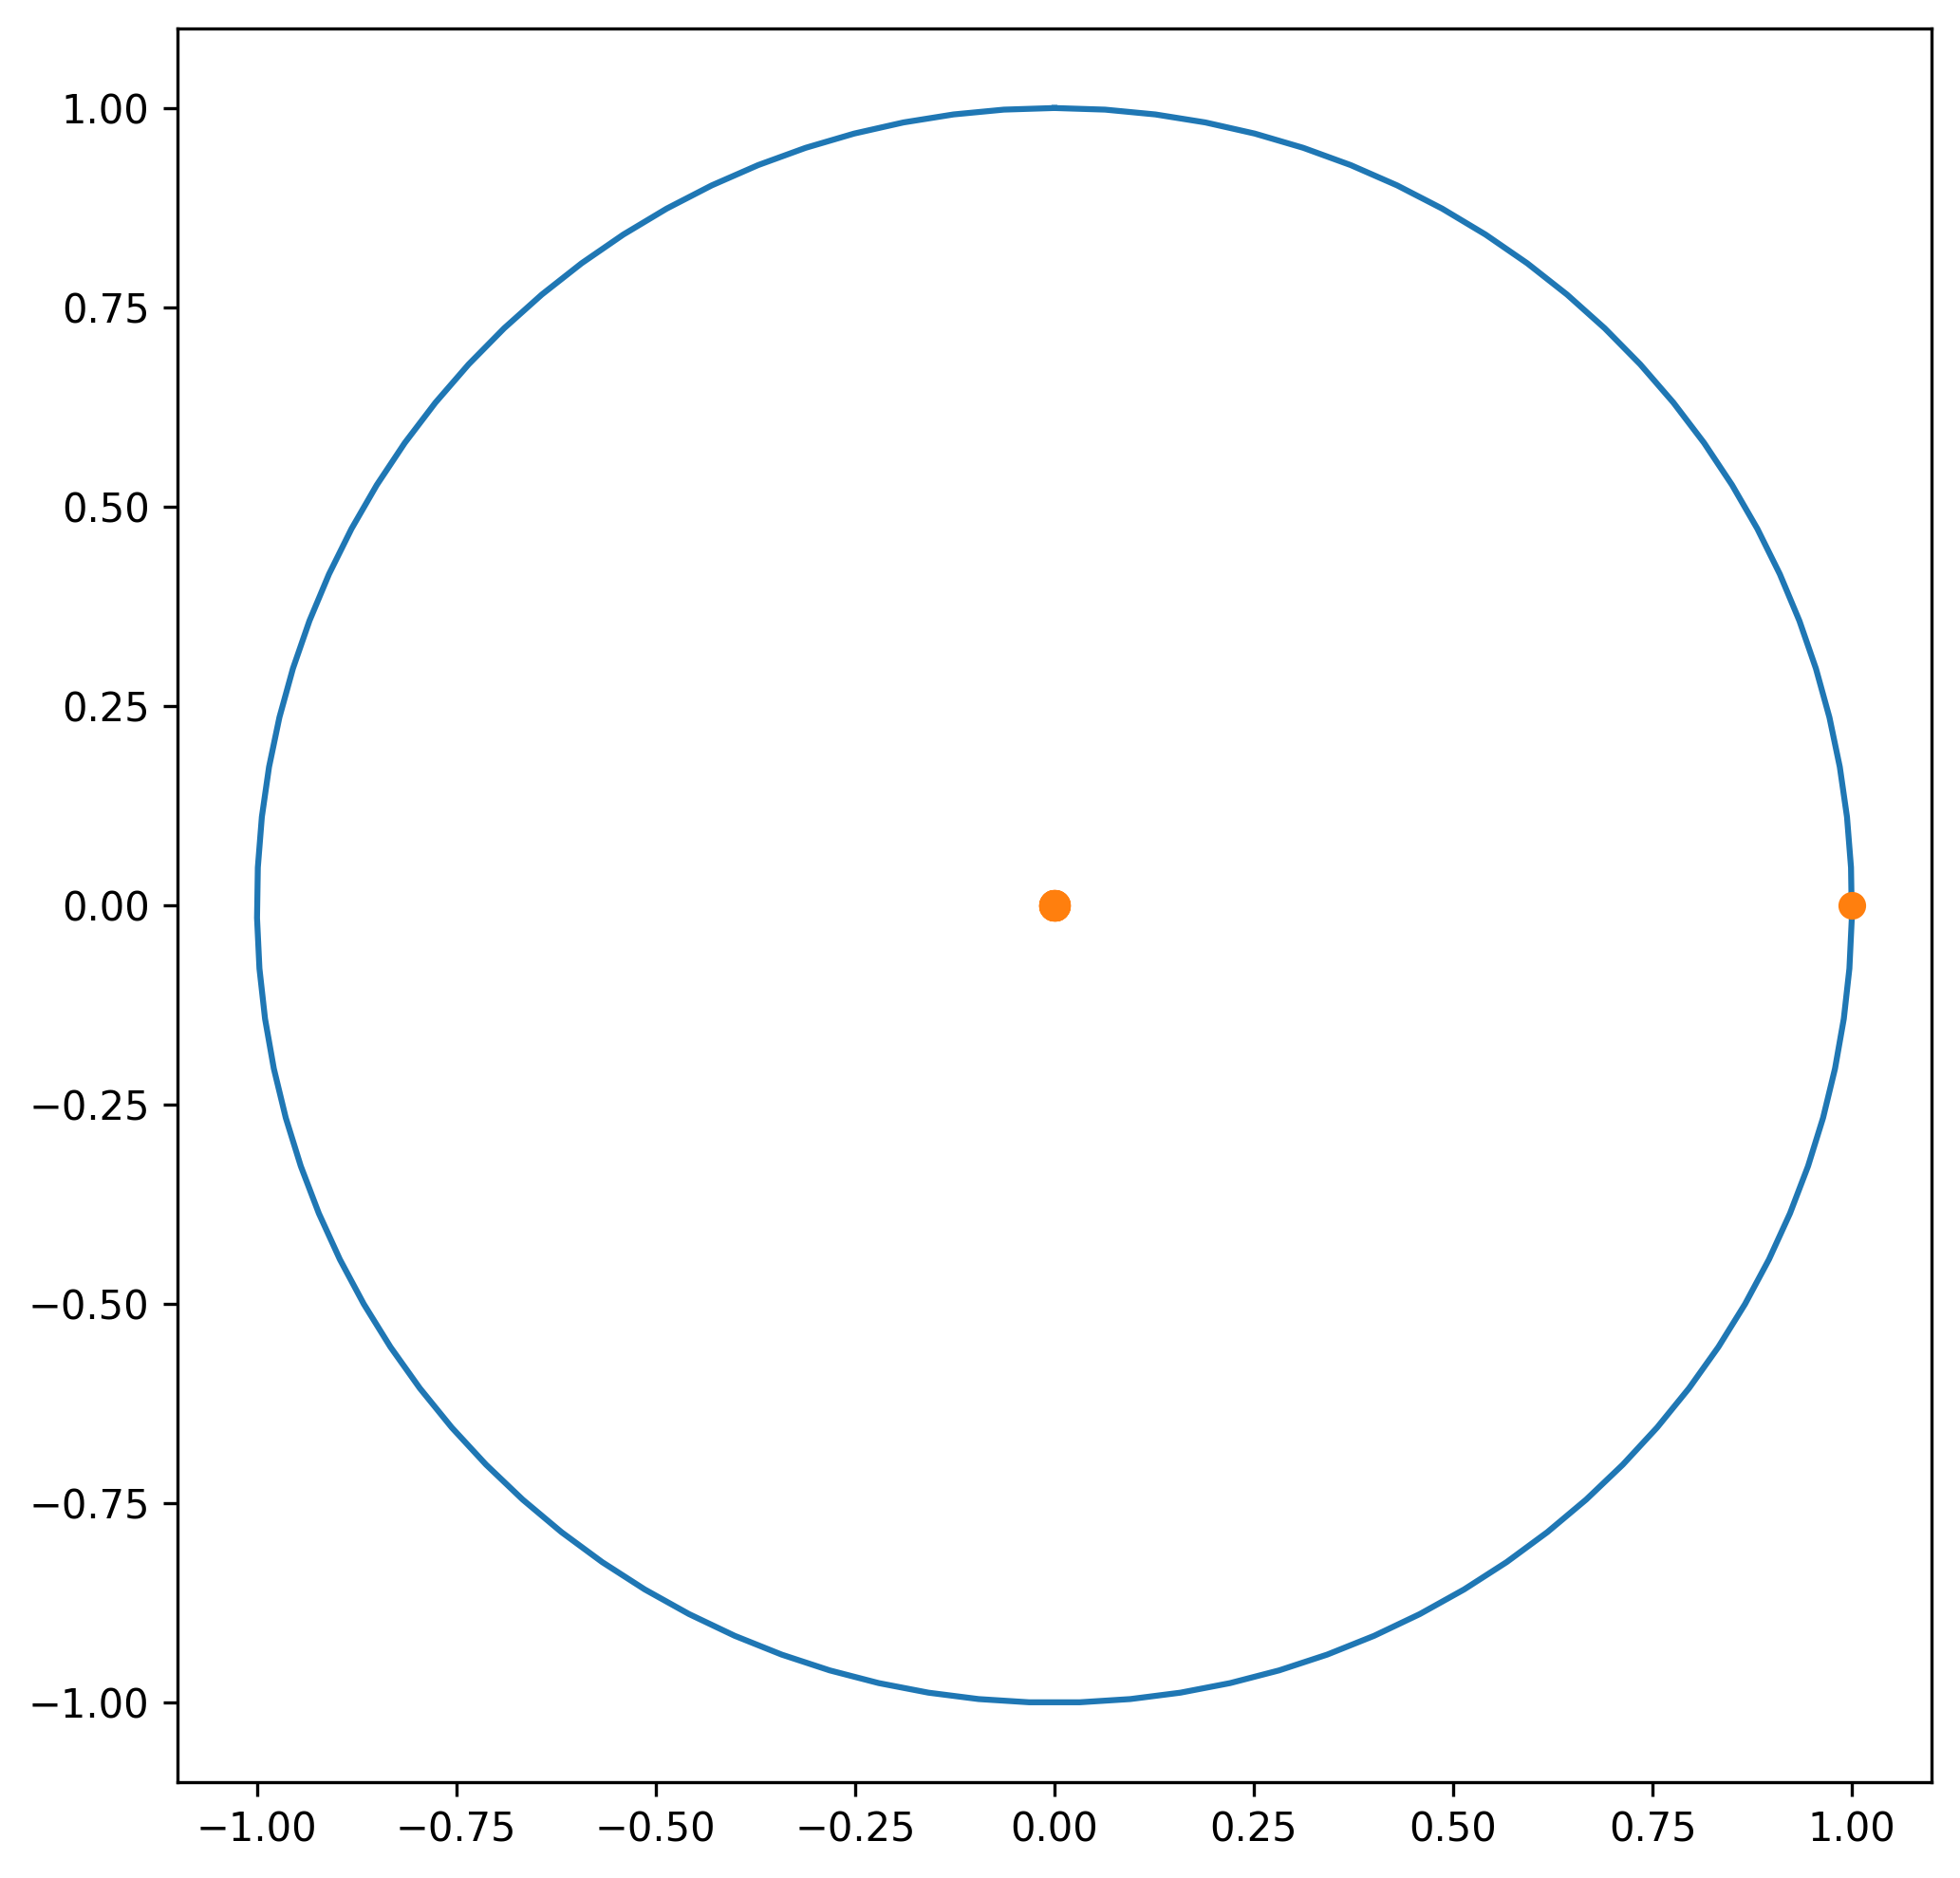

In [7]:
choi = kraus_to_choi(kraus_full)
spectrum_full = choi_spectrum(choi)

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle)
plt.plot(spectrum_full[:,0], spectrum_full[:,1], "o")
plt.show()